In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('../src/')

In [3]:
from ClusterEnsembles import *
from preprocess import *
from settings import *

In [4]:
# set plotting params
import matplotlib as mpl
import plots
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.reload_library()
rcparams = plots.stdrcparams()
mpl.rcParams.update(rcparams)

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

In [6]:
mimic_train, mimic_test = load_and_prepare_dataset(dataset='mimic', feature_set='sofs+vtls', \
                                imputation_strategy='Complete_cases', scaler_name='MM', holdout=.5)

carpediem_train, carpediem_test = load_and_prepare_dataset(dataset='carpediem', feature_set='sofs+vtls', \
                                imputation_strategy='CarryLastForward_limit2', scaler_name='KBD', holdout=.1)

In [7]:
mapping_dict = {
    'respiration_24hours': 'P_F_ratio_points',
    'coagulation_24hours': 'platelet_points',
    'liver_24hours': 'bilirubin_points',
    'cardiovascular_24hours': 'htn_points',
    'gcs_motor': 'GCS_motor_response',
    'gcs_verbal': 'GCS_verbal_response',
    'gcs_eyes': 'GCS_eye_opening',
    'renal_24hours': 'renal_points',
    'heart_rate': 'Heart_rate',
    'sbp': 'Systolic_blood_pressure',
    'dbp': 'Diastolic_blood_pressure',
    'mbp': 'Mean_arterial_pressure',
    'resp_rate': 'Respiratory_rate',
    'temperature': 'Temperature',
    'spo2': 'Oxygen_saturation'
}


In [8]:
mimic_train = mimic_train.rename(columns=mapping_dict)[carpediem_train.columns]
mimic_test = mimic_test.rename(columns=mapping_dict)[carpediem_test.columns]

In [9]:
X_train_script = carpediem_train.dropna(subset='edps').iloc[:, :-1]
y_train_script = carpediem_train.dropna(subset='edps').iloc[:, -1]

X_test_script = carpediem_test.dropna(subset='edps').iloc[:, :-1]
y_test_script = carpediem_test.dropna(subset='edps').iloc[:, -1]

X_train_mimic = mimic_train.dropna(subset='edps').iloc[:, :-1]
y_train_mimic = mimic_train.dropna(subset='edps').iloc[:, -1]

X_test_mimic = mimic_test.dropna(subset='edps').iloc[:, :-1]
y_test_mimic = mimic_test.dropna(subset='edps').iloc[:, -1]

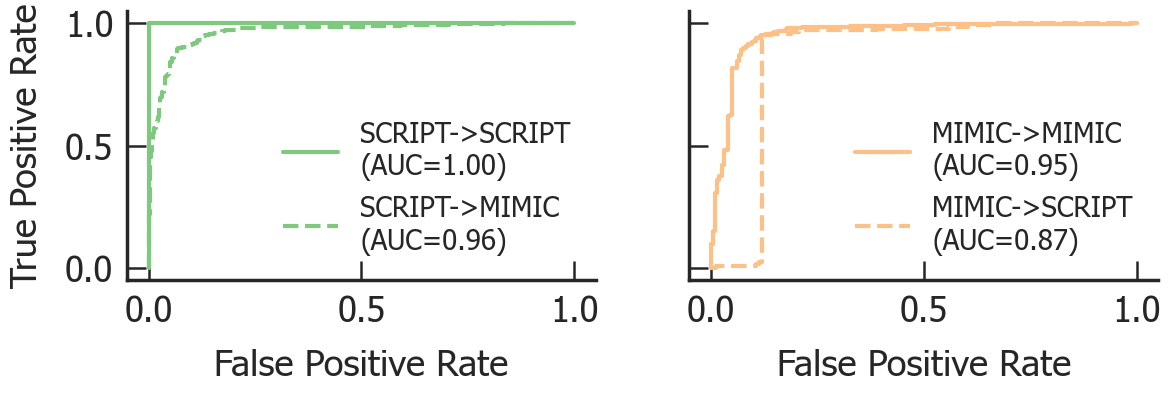

In [10]:
fig, axs = plt.subplots(1, 2, figsize=plots.stdfigsize(nx=2, ny=1, scale=0.5, ratio=1.9), constrained_layout=False, sharey=True)

clf = make_pipeline(PCA(n_components=4), SVC(class_weight='balanced'))
clf.fit(X_train_script, y_train_script)

y_pred_proba = clf.decision_function(X_test_script)
fpr, tpr, thresholds = roc_curve(y_test_script, y_pred_proba, pos_label='home') 
roc_auc = auc(fpr, tpr)
axs[0].plot(fpr, tpr, label='SCRIPT->SCRIPT\n(AUC=%.2f)' % roc_auc, color='#7fc97f', lw=3)

y_pred_proba = clf.decision_function(pd.concat([X_train_mimic, X_test_mimic]))
fpr, tpr, thresholds = roc_curve(pd.concat([y_train_mimic, y_test_mimic]), y_pred_proba, pos_label='home')
roc_auc = auc(fpr, tpr)
axs[0].plot(fpr, tpr, label='SCRIPT->MIMIC\n(AUC=%.2f)' % roc_auc, color='#7fc97f', linestyle='--', lw=3)

clf = make_pipeline(PCA(n_components=2), SVC(class_weight='balanced'))
clf.fit(X_train_mimic, y_train_mimic)

y_pred_proba = clf.decision_function(X_test_mimic)
fpr, tpr, thresholds = roc_curve(y_test_mimic, y_pred_proba, pos_label='home')
roc_auc = auc(fpr, tpr)
axs[1].plot(fpr, tpr, label='MIMIC->MIMIC\n(AUC=%.2f)' % roc_auc, color='#fdc086', lw=3)

y_pred_proba = clf.decision_function(pd.concat([X_train_script, X_test_script]))
fpr, tpr, thresholds = roc_curve(pd.concat([y_train_script, y_test_script]), y_pred_proba, pos_label='home')
roc_auc = auc(fpr, tpr)
axs[1].plot(fpr, tpr, label='MIMIC->SCRIPT\n(AUC=%.2f)' % roc_auc, color='#fdc086', linestyle='--', lw=3)

for ax in axs:
    if ax == axs[0]:
        ax.set_ylabel('True Positive Rate', fontsize=26)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('False Positive Rate', fontsize=26)
    ax.legend(frameon=False)